In [45]:
import os
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy.optimize import root
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
data_dir = "data/krylov_data"
exact_file = "hubbard_exact.h5"
l = 2
output_filename = f"hubbard_{l}_error_ut_2.pdf"
d_max = 14
d_min = 3

if l == 2:
    num_cnot = 22
elif l == 3:
    num_cnot = 191
elif l == 4:
    num_cnot = 472
else:
    raise ValueError(f"Invalid dimension {l}")

In [47]:
all_files = os.listdir(data_dir)
assert exact_file in all_files
ev_files = [f for f in all_files if "eigenvalues" in f]
print(len(ev_files))

11


In [48]:
# Get the exact energy.
f_exact = h5py.File(data_dir + "/" + exact_file, "r")
energy_exact = np.min(f_exact["energies"])
print(f"Exact energy is {energy_exact}.")
f_exact.close()

Exact energy is (1.0717967697244906+0j).


In [49]:
# subspace_files = [f for f in all_files if "subspace" in f]
# for i in range(len(subspace_files)):
#     f_subspace = h5py.File(data_dir + "/" + subspace_files[i])
#     ref_energy = f_subspace["reference_energy"][()]
#     f_subspace.close()
#     print(f"Reference energy = {ref_energy}")

In [50]:
dfs = []
for evf in ev_files:
    fname = data_dir + "/" + evf
    # Get the number of steps.
    f = h5py.File(fname, "r")
    steps = f["steps"][()]
    f.close()
    # Get the upper bound.
    # fname2 = fname.replace("eigenvalues", "bound")
    # bound_df = pd.read_hdf(fname2)
    # Get the dataframe with energy vs. d
    df = pd.read_hdf(fname, key="eigenvalues")
    df["error"] = abs(df["energy"] - energy_exact)
    df["steps"] = steps
    df["num_2q"] = steps * num_cnot
    df.set_index("d")
    # df_concat = pd.concat([df, bound_df], axis=1)
    # dfs.append(df_concat)
    dfs.append(df)
df_total = pd.concat(dfs)
print(df_total)

     d           eps    energy  num_pos     error  steps  num_2q
i                                                               
0    3  1.000000e-12  1.072688        3  0.000891    150    3300
1    4  1.000000e-12  1.072114        4  0.000317    150    3300
2    5  1.000000e-12  1.072029        5  0.000232    150    3300
3    6  1.000000e-12  1.071962        6  0.000165    150    3300
4    7  1.000000e-12  1.071920        7  0.000123    150    3300
..  ..           ...       ...      ...       ...    ...     ...
23  26  1.000000e-12  1.071702       18  0.000094     20     440
24  27  1.000000e-12  1.071685       19  0.000112     20     440
25  28  1.000000e-12  1.071666       19  0.000131     20     440
26  29  1.000000e-12  1.071640       20  0.000156     20     440
27  30  1.000000e-12  1.071595       20  0.000202     20     440

[308 rows x 7 columns]


In [51]:
df_small = df_total[df_total["d"] >= 20]
print(df_small)

     d           eps    energy  num_pos         error  steps  num_2q
i                                                                   
17  20  1.000000e-12  1.071799       15  2.635220e-06    150    3300
18  21  1.000000e-12  1.071798       15  1.211311e-06    150    3300
19  22  1.000000e-12  1.071796       16  2.703705e-07    150    3300
20  23  1.000000e-12  1.071795       17  1.604454e-06    150    3300
21  24  1.000000e-12  1.071794       17  2.610669e-06    150    3300
..  ..           ...       ...      ...           ...    ...     ...
23  26  1.000000e-12  1.071702       18  9.435408e-05     20     440
24  27  1.000000e-12  1.071685       19  1.120131e-04     20     440
25  28  1.000000e-12  1.071666       19  1.305397e-04     20     440
26  29  1.000000e-12  1.071640       20  1.564190e-04     20     440
27  30  1.000000e-12  1.071595       20  2.022630e-04     20     440

[121 rows x 7 columns]


In [52]:
df_inter = df_total[df_total["d"] <= d_max]
df_small = df_inter[df_inter["d"] >= d_min]
print(df_small.head())

   d           eps    energy  num_pos     error  steps  num_2q
i                                                             
0  3  1.000000e-12  1.072688        3  0.000891    150    3300
1  4  1.000000e-12  1.072114        4  0.000317    150    3300
2  5  1.000000e-12  1.072029        5  0.000232    150    3300
3  6  1.000000e-12  1.071962        6  0.000165    150    3300
4  7  1.000000e-12  1.071920        7  0.000123    150    3300


In [53]:
chemical_accuracy = 0.00159 * l ** 2
print(f"Chemical accuracy is {chemical_accuracy} ha.")

Chemical accuracy is 0.00636 ha.


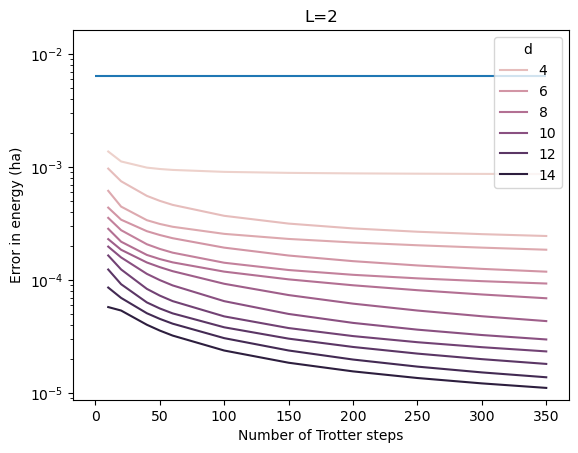

In [58]:
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.hlines(chemical_accuracy, 0, 350)
sns.lineplot(ax=ax, data=df_small, x="steps", y="error", hue="d")
plt.ylim(top=chemical_accuracy+ 0.01)
ax.set_xlabel("Number of Trotter steps")
ax.set_ylabel("Error in energy (ha)")
plt.title(f"L={l}")
plt.savefig(output_filename)

In [55]:
def find_num_steps(steps, errors, accuracy, t0):
    """Find the number of steps for a given accuracy by interpolation."""

    assert np.min(errors) <= accuracy <= np.max(errors),\
        f"Accuracy {accuracy} must be between {np.min(errors)} and {np.max(errors)}"
    spline = CubicSpline(steps, errors)
    solution = root(lambda nt: spline(nt) - accuracy, t0)
    if not solution.success:
        print("Solver did not converge.")
    return solution.x

In [56]:
for d in range(3, 17):
    df_d = df_total[df_total["d"] == d]
    errors = df_d["error"].to_numpy()
    print(d, np.min(errors), np.max(errors))

3 0.0008702102407878165 0.001377705368076132
4 0.00024620117826912313 0.0009726664431655152
5 0.00018615202112348683 0.0006182999585988558
6 0.00011896242428344195 0.0004390359961388146
7 9.34554317915115e-05 0.00035630366008154724
8 6.919633922364277e-05 0.00028523473710206915
9 4.3445563936206355e-05 0.0002310421055504719
10 2.988204965004293e-05 0.0001982637815827193
11 2.3421532742817774e-05 0.00016547424158797064
12 1.81499979183819e-05 0.0001242870447644151
13 1.3825004846035327e-05 8.607554942963169e-05
14 1.1130385347835059e-05 5.781684550321131e-05
15 9.118922531747842e-06 3.9263161705216376e-05
16 7.0355420564993665e-06 2.5516310585560475e-05


In [57]:
# For each given error, find how many steps it would take to produce, along wih the required d.
errs = [0.1, 0.1, 1e-2, 1e-2, 1e-2, 1e-3, 5e-4]
ds = [3, 4, 7, 8, 9, 14, 15]
nt0 = [50, 50, 250, 200, 200, 200, 200] # Guess at number of steps.

for err, d, nt in zip(errs, ds, nt0):
    df_d = df_total[df_total["d"] == d]
    df_d.sort_values("steps", inplace=True)
    errors = df_d["error"].to_numpy()
    steps = df_d["steps"].to_numpy()
    steps = find_num_steps(steps, errors, err, nt)
    print(err, d, steps)

/var/folders/rv/3v7hvpgn6ks14zr4w90jz4zc0000gn/T/ipykernel_3673/1125365208.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d.sort_values("steps", inplace=True)


AssertionError: Accuracy 0.1 must be between 0.0008702102407878165 and 0.001377705368076132